<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Сезонность-по-часам" data-toc-modified-id="Сезонность-по-часам-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сезонность по часам</a></span></li><li><span><a href="#Сезонность-по-дням" data-toc-modified-id="Сезонность-по-дням-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сезонность по дням</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Константная модель</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from datetime import datetime 

import warnings

In [2]:
RANDOM_STATE = 7
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [4]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

### Сезонность по часам

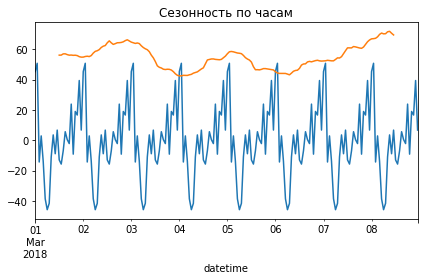

In [5]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-08'])
decomposed.seasonal.plot(ax=plt.gca())
decomposed.trend.plot(ax=plt.gca()) 

plt.title('Сезонность по часам')
plt.tight_layout()

Видна недельная цикличность.

### Сезонность по дням

In [6]:
df_day = df.resample('1D').sum()
decomposed = seasonal_decompose(df_day)

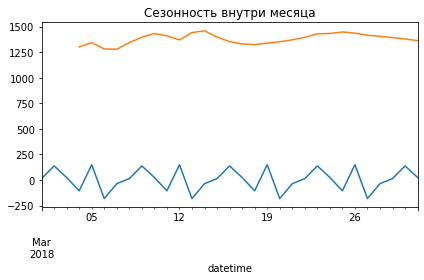

In [7]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca(), x = 'weekday')
decomposed.trend['2018-03-01':'2018-03-31'].plot(ax=plt.gca(), x = 'weekday') 
plt.title('Сезонность внутри месяца')
plt.tight_layout()

Видна сезонность внутри дня: ночной спад и вечерний пик

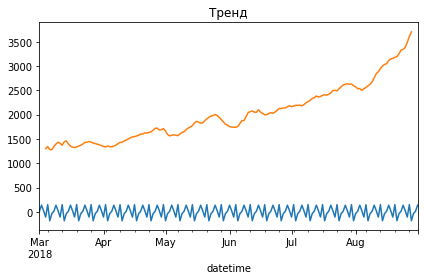

In [8]:
decomposed.seasonal['2018-03-01':'2018-08-31'].plot(ax=plt.gca())
decomposed.trend['2018-03-01':'2018-08-31'].plot(ax=plt.gca()) 
plt.title('Тренд')
plt.tight_layout()

Виден восходящий тренд с марта по август.

## Обучение

### Подготовка признаков

In [9]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
display ('df', df)
df_alt = pd.DataFrame()

'df'

,num_orders,year,month,day,dayofweek
datetime,,,,,
2018-03-01 00:00:00,124,2018,3,1,3
2018-03-01 01:00:00,85,2018,3,1,3
2018-03-01 02:00:00,71,2018,3,1,3
2018-03-01 03:00:00,66,2018,3,1,3
2018-03-01 04:00:00,43,2018,3,1,3
...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4
2018-08-31 20:00:00,154,2018,8,31,4
2018-08-31 21:00:00,159,2018,8,31,4


In [10]:
def make_lag_rolling(dataframe, max_lag, rolling_mean_size):
    df_alt = dataframe.copy()
    for lag in range(1, max_lag + 1):
        df_alt['lag_{}'.format(lag)] = df_alt['num_orders'].shift(lag)
    df_alt['rolling_mean'] = df_alt['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    df_alt.dropna(inplace = True)
    return df_alt

In [11]:
def splitting (dataframe):
    features = dataframe.drop(columns = ['num_orders'], axis = 1)
    target = dataframe['num_orders']
    train_features, prevalid_features, train_target, prevalid_target = train_test_split(features,target, shuffle=False, test_size=0.2)
    valid_features, test_features, valid_target, test_target = train_test_split(prevalid_features,prevalid_target, shuffle=False, test_size=0.5)
    return train_features, valid_features, train_target, valid_target, test_features, test_target

### Линейная регрессия

In [12]:
model_LR = LinearRegression()
min_error = 1000
for max_lag in range (2, 103, 10):
    for rolling_mean_size in range (1, 1101, 100):
        df_alt = make_lag_rolling(df, max_lag, rolling_mean_size)
        train_features, valid_features, train_target, valid_target = splitting (df_alt)[:4]
        #display(train_features)
        #display(valid_features)
        #display(train_target)
        #display(valid_target)     
        model_LR.fit(train_features, train_target)
        pred_valid = model_LR.predict(valid_features)
        error = mean_squared_error(valid_target, pred_valid, squared = False)
        if error < min_error:
            min_error = error
            best_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            best_df = df_alt.copy()
print("Лучший RMSE обучающей выборки:", min_error, 'best_lag:', best_lag, 'best_rolling_mean_size:', best_rolling_mean_size)

Лучший RMSE обучающей выборки: 30.057378826802793 best_lag: 102 best_rolling_mean_size: 101


### Catboost

In [13]:
model = CatBoostRegressor(random_state = RANDOM_STATE)

parameters = {'n_estimators': range (100, 101, 10),
          'depth': range (2, 7)
       }
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=0,
   )
start_time = datetime.now()
gsearch_cat_boost = GridSearchCV(estimator=CatBoostRegressor(), param_grid = parameters, scoring = 'neg_root_mean_squared_error', cv = ts_cv,
          verbose=False, n_jobs = -1)
gsearch_cat_boost.fit(train_features, train_target,verbose=False)
cat_boost_time_fit = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(cat_boost_time_fit))
print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n", -gsearch_cat_boost.best_score_)
print("\n The best parameters across ALL searched params:\n", gsearch_cat_boost.best_params_)

Time elapsed (hh:mm:ss.ms) 0:01:10.278060
 Results from Grid Search 

 The best score across ALL searched params:
 24.286637992640383

 The best parameters across ALL searched params:
 {'depth': 6, 'n_estimators': 100}


## Тестирование

### Линейная регрессия

In [14]:
test_features, test_target = splitting (best_df)[4:]
pred_test_LR= model_LR.predict(test_features)
print("RMSE тестовой выборки: ", mean_squared_error(test_target,pred_test_LR, squared = False))

RMSE тестовой выборки:  40.34098922859229


### Catboost

In [15]:
pred_test_CB = gsearch_cat_boost.predict(test_features)
print("RMSE тестовой выборки: ", mean_squared_error(test_target,pred_test_CB, squared = False))

RMSE тестовой выборки:  43.67784875784098


### Константная модель

In [16]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(train_features, train_target)
pred_test_Dummy = dummy_model.predict(test_features)
print('RMSE', mean_squared_error(test_target, pred_test_Dummy, squared = False))

RMSE 81.91116634410584


## Вывод

Наилучший результат у линейной регресии - 40. Это ниже порога ошибки - 48 и лучше Константной модели.
Такой результат достигается при создании признаков с лагом до 102 часа и скользящим средним с окном в 101 час.